#  Step 7: GNN Model Training & Embedding Comparison

##  **EXECUTION ORDER GUIDE**
**Execute cells in this exact order for complete analysis:**

1. **Setup & Imports** (Cell 1) - Initialize libraries and environment
2. **Data Loading Functions** (Cell 2) - Define data loading utilities  
3. **Load Training Data** (Cell 3) - Load both One-Hot and ESM datasets
4. **Create Data Splits** (Cell 4) - Generate train/validation/test splits
5. **Model Architectures** (Cell 5) - Define all 5 model architectures
6. **Training Functions** (Cell 6) - Define training and evaluation functions
7. **Initialize Models** (Cell 7) - Create model instances for both embedding types
8. **Train All Models** (Cell 8) - Execute complete training pipeline
9. **Create Comparison Results** (Cell 9) - Generate performance comparison tables
10. **Visualize Results** (Cell 10) - Create comprehensive plots and analysis

##  **Expected Outputs:**
- **Trained Models**: 10 models saved in `models_onehot/` and `models_esm/`
- **Results Files**: Performance CSV, plots, and analysis saved in `results/`
- **Training Time**: ~60-90 minutes total execution time

---

## Overview
This notebook trains and compares Graph Neural Network models for drug-target interaction prediction using two different protein embedding approaches:

1. **One-Hot Embeddings**: 116 interpretable biochemical features
2. **ESM Embeddings**: 1280-dimensional transformer-based protein representations

## Model Architectures Tested
- MLP Baseline
- Original GraphSAGE
- Improved GraphSAGE  
- Performance Booster
- Accuracy Optimized

## Training Strategy
- **Accuracy Maximization**: Direct optimization of classification accuracy
- **Cross-validation**: Robust evaluation with train/validation/test splits
- **Comprehensive Metrics**: Accuracy, AUC, Precision, Recall, F1-Score

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE, GCNConv, global_mean_pool, global_max_pool
from torch_geometric.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from tqdm import tqdm
import os
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cpu


## 1️⃣ Setup and Imports
**Execute this cell first to set up the environment**

In [ ]:
# Data loading functions
def load_training_data(pairs_file="../data/step6_training_pairs.csv", 
                      embeddings_file="../data/step4_onehot_embeddings.csv",
                      graphs_dir="../data/graphs/",
                      embedding_type="onehot"):
    """Load and prepare training data"""
    print(f"Loading training pairs for {embedding_type} embeddings...")
    pairs_df = pd.read_csv(pairs_file)
    
    print(f"Loading {embedding_type} protein embeddings...")
    embeddings_df = pd.read_csv(embeddings_file)
    
    print(f"Embeddings file shape: {embeddings_df.shape}")
    print(f"Embeddings file columns: {list(embeddings_df.columns[:10])}...")  # Show first 10 columns
    print(f"Sample data types: {embeddings_df.dtypes.value_counts()}")
    
    # Extract ChEMBL IDs from protein embeddings (format: P00519|CHEMBL1862|Tyrosine-protein)
    if "id" in embeddings_df.columns:
        embeddings_df["chembl_id"] = embeddings_df["id"].str.split("|").str[1]
        id_col = "id"
    elif "protein_id" in embeddings_df.columns:
        embeddings_df["chembl_id"] = embeddings_df["protein_id"].str.split("|").str[1]
        id_col = "protein_id"
    else:
        # Fallback - assume first column contains IDs
        id_col = embeddings_df.columns[0]
        embeddings_df["chembl_id"] = embeddings_df[id_col].str.split("|").str[1]
    
    embeddings_dict = {}
    for _, row in embeddings_df.iterrows():
        chembl_id = row["chembl_id"]
        # Get all embedding columns (exclude ID and chembl_id columns)
        embedding_cols = [col for col in embeddings_df.columns if col not in [id_col, 'chembl_id']]
        
        # Extract embedding values and ensure they are numeric
        embedding_values = row[embedding_cols].values
        
        # Convert to numeric, handling any non-numeric values
        try:
            # Try to convert to float, this will handle string numbers
            numeric_values = pd.to_numeric(embedding_values, errors='coerce')
            
            # Check for any NaN values (from failed conversions)
            if pd.isna(numeric_values).any():
                print(f"Warning: Found non-numeric values in embeddings for {chembl_id}, skipping...")
                continue
                
            embeddings_dict[chembl_id] = torch.tensor(numeric_values.astype(np.float32), dtype=torch.float32)
            
        except Exception as e:
            print(f"Error processing embeddings for {chembl_id}: {e}")
            continue
    
    print(f"Successfully loaded {len(embeddings_dict)} protein embeddings")
    if len(embeddings_dict) > 0:
        sample_embedding = list(embeddings_dict.values())[0]
        print(f"Embedding dimension: {sample_embedding.shape[0]}")
    else:
        raise ValueError("No valid embeddings were loaded! Check your embedding file format.")
    
    print("Loading molecular graphs...")
    # Load available graphs
    available_graphs = set()
    for filename in os.listdir(graphs_dir):
        if filename.endswith('.pt'):
            available_graphs.add(filename.replace('.pt', ''))
    
    # Filter pairs to only include available data
    valid_pairs = []
    for _, row in pairs_df.iterrows():
        drug_id = row['drug_id']
        target_id = row['target_id']
        if drug_id in available_graphs and target_id in embeddings_dict:
            valid_pairs.append(row)
    
    valid_pairs_df = pd.DataFrame(valid_pairs)
    print(f"Found {len(valid_pairs_df)} valid training pairs")
    print(f"Positive samples: {(valid_pairs_df['label'] == 1).sum()}")
    print(f"Negative samples: {(valid_pairs_df['label'] == 0).sum()}")
    
    return valid_pairs_df, embeddings_dict, graphs_dir

print("✅ Data loading functions defined!")

LOADING ONE-HOT EMBEDDING DATA
Loading training pairs for onehot embeddings...
Loading onehot protein embeddings...
Embeddings file shape: (188, 117)
Embeddings file columns: ['id', 'length', 'count_A', 'count_R', 'count_N', 'count_D', 'count_C', 'count_Q', 'count_E', 'count_G']...
Sample data types: float64    95
int64      21
object      1
Name: count, dtype: int64
Successfully loaded 188 protein embeddings
Embedding dimension: 116
Loading molecular graphs...
Found 10584 valid training pairs
Positive samples: 4748
Negative samples: 5836

LOADING ESM EMBEDDING DATA
Loading training pairs for ESM embeddings...
Loading ESM protein embeddings...
Embeddings file shape: (187, 1281)
Embeddings file columns: ['id', 'feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8']...
Sample data types: float64    1280
object        1
Name: count, dtype: int64
Found 10584 valid training pairs
Positive samples: 4748
Negative samples: 5836

LOADING ESM EMBEDDING DATA
Load

## 3️⃣ Load Training Data
**Load both One-Hot and ESM embedding datasets**

In [ ]:
# Load both datasets for comparison
print("="*80)
print("LOADING ONE-HOT EMBEDDING DATA")
print("="*80)
pairs_df_onehot, protein_embeddings_onehot, graphs_dir = load_training_data(
    pairs_file="../data/step6_training_pairs.csv",
    embeddings_file="../data/step4_onehot_embeddings.csv",
    embedding_type="onehot"
)

print("\n" + "="*80)
print("LOADING ESM EMBEDDING DATA")
print("="*80)
pairs_df_esm, protein_embeddings_esm, _ = load_training_data(
    pairs_file="../data/step6.1_esm_training_pairs.csv",
    embeddings_file="../data/step4.1_esm_protein_embeddings.csv",
    embedding_type="ESM"
)

print("✅ Both datasets loaded successfully!")

## 4️⃣ Create Data Splits
**Generate train/validation/test splits and data loaders**

In [ ]:
# Custom Dataset Class
class DrugTargetDataset(torch.utils.data.Dataset):
    def __init__(self, pairs_df, protein_embeddings, graphs_dir):
        self.pairs = pairs_df.reset_index(drop=True)
        self.protein_embeddings = protein_embeddings
        self.graphs_dir = graphs_dir
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        row = self.pairs.iloc[idx]
        drug_id = row['drug_id']
        target_id = row['target_id']
        label = torch.tensor(row['label'], dtype=torch.long)
        
        # Load drug graph
        graph_path = os.path.join(self.graphs_dir, f"{drug_id}.pt")
        drug_graph = torch.load(graph_path, map_location='cpu', weights_only=False)
        
        # Get protein embedding
        protein_embedding = self.protein_embeddings[target_id]
        
        return drug_graph, protein_embedding, label

def create_data_splits(pairs_df, protein_embeddings, graphs_dir, embedding_type):
    """Create train/val/test splits for a specific embedding type"""
    print(f"\nCreating data splits for {embedding_type} embeddings...")
    
    # Split data into train/validation/test
    train_pairs, temp_pairs = train_test_split(pairs_df, test_size=0.3, random_state=42, stratify=pairs_df['label'])
    val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42, stratify=temp_pairs['label'])

    print(f"Training set: {len(train_pairs)} samples")
    print(f"Validation set: {len(val_pairs)} samples") 
    print(f"Test set: {len(test_pairs)} samples")

    # Create datasets
    train_dataset = DrugTargetDataset(train_pairs, protein_embeddings, graphs_dir)
    val_dataset = DrugTargetDataset(val_pairs, protein_embeddings, graphs_dir)
    test_dataset = DrugTargetDataset(test_pairs, protein_embeddings, graphs_dir)

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'pairs': {
            'train': train_pairs,
            'val': val_pairs,
            'test': test_pairs
        }
    }

# Create data splits for both embedding types
data_splits_onehot = create_data_splits(pairs_df_onehot, protein_embeddings_onehot, graphs_dir, "One-Hot")
data_splits_esm = create_data_splits(pairs_df_esm, protein_embeddings_esm, graphs_dir, "ESM")

print("✅ Data loading complete for both embedding types!")


Creating data splits for One-Hot embeddings...
Training set: 7408 samples
Validation set: 1588 samples
Test set: 1588 samples

Creating data splits for ESM embeddings...
Training set: 7287 samples
Validation set: 1562 samples
Test set: 1562 samples
Data loading complete for both embedding types!


c:\Users\FEL_BA_01\Desktop\MSc_Project\.venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\FEL_BA_01\Desktop\MSc_Project\.venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 5️⃣ Model Architectures
**Define all 5 model architectures for training**

In [ ]:
# Model Architectures

# 1. MLP Baseline
class MLPBaseline(nn.Module):
    def __init__(self, drug_input_dim, protein_input_dim, hidden_dim=256):
        super(MLPBaseline, self).__init__()
        
        # Simple concatenation approach - use fixed drug feature size
        self.drug_feature_dim = 128  # Fixed size for drug representation
        combined_dim = self.drug_feature_dim + protein_input_dim
        
        # Linear layer to convert variable graph to fixed size
        self.drug_encoder = nn.Linear(drug_input_dim, self.drug_feature_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 2)
        )
    
    def forward(self, drug_graph, protein_embedding):
        # Average node features for simple baseline
        drug_features = global_mean_pool(drug_graph.x, drug_graph.batch)
        drug_features = self.drug_encoder(drug_features)
        
        # Simple concatenation
        combined = torch.cat([drug_features, protein_embedding], dim=1)
        return self.classifier(combined)

# 2. Original GraphSAGE
class OriginalGraphSAGE(nn.Module):
    def __init__(self, node_input_dim, protein_input_dim, hidden_dim=128):
        super(OriginalGraphSAGE, self).__init__()
        
        self.graph_convs = nn.ModuleList([
            GraphSAGE(node_input_dim, hidden_dim, num_layers=2),
            GraphSAGE(hidden_dim, hidden_dim, num_layers=2)
        ])
        
        # Graph-level pooling
        self.graph_pool = global_mean_pool
        
        # Combine drug and protein representations
        combined_dim = hidden_dim + protein_input_dim
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, drug_graph, protein_embedding):
        x, edge_index, batch = drug_graph.x, drug_graph.edge_index, drug_graph.batch
        
        # Graph convolutions
        for conv in self.graph_convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        
        # Pool to graph level
        drug_repr = self.graph_pool(x, batch)
        
        # Combine representations
        combined = torch.cat([drug_repr, protein_embedding], dim=1)
        return self.classifier(combined)

# 3. Improved GraphSAGE
class ImprovedGraphSAGE(nn.Module):
    def __init__(self, node_input_dim, protein_input_dim, hidden_dim=128):
        super(ImprovedGraphSAGE, self).__init__()
        
        self.node_encoder = nn.Linear(node_input_dim, hidden_dim)
        
        self.graph_convs = nn.ModuleList([
            GraphSAGE(hidden_dim, hidden_dim, num_layers=1),
            GraphSAGE(hidden_dim, hidden_dim, num_layers=1),
            GraphSAGE(hidden_dim, hidden_dim, num_layers=1)
        ])
        
        # Improved pooling with both mean and max
        self.graph_pool_mean = global_mean_pool
        self.graph_pool_max = global_max_pool
        
        # Enhanced combination
        combined_dim = hidden_dim * 2 + protein_input_dim  # mean + max pooling
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, 2)
        )
    
    def forward(self, drug_graph, protein_embedding):
        x, edge_index, batch = drug_graph.x, drug_graph.edge_index, drug_graph.batch
        
        # Encode nodes
        x = self.node_encoder(x)
        x = F.relu(x)
        
        # Graph convolutions with residual connections
        for conv in self.graph_convs:
            x_new = conv(x, edge_index)
            x = F.relu(x_new + x)  # Residual connection
        
        # Dual pooling
        drug_repr_mean = self.graph_pool_mean(x, batch)
        drug_repr_max = self.graph_pool_max(x, batch)
        drug_repr = torch.cat([drug_repr_mean, drug_repr_max], dim=1)
        
        # Combine representations
        combined = torch.cat([drug_repr, protein_embedding], dim=1)
        return self.classifier(combined)

# 4. Performance Booster
class PerformanceBooster(nn.Module):
    def __init__(self, node_input_dim, protein_input_dim, hidden_dim=128):
        super(PerformanceBooster, self).__init__()
        
        self.node_encoder = nn.Linear(node_input_dim, hidden_dim)
        
        # Multiple graph convolution layers
        self.graph_convs = nn.ModuleList([
            GCNConv(hidden_dim, hidden_dim),
            GCNConv(hidden_dim, hidden_dim),
            GCNConv(hidden_dim, hidden_dim),
            GCNConv(hidden_dim, hidden_dim)
        ])
        
        # Attention mechanism for node importance
        self.attention = nn.Linear(hidden_dim, 1)
        
        # Enhanced protein processing
        self.protein_encoder = nn.Sequential(
            nn.Linear(protein_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Sophisticated combination
        combined_dim = hidden_dim + hidden_dim  # drug + protein
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, drug_graph, protein_embedding):
        x, edge_index, batch = drug_graph.x, drug_graph.edge_index, drug_graph.batch
        
        # Encode nodes
        x = self.node_encoder(x)
        x = F.relu(x)
        
        # Graph convolutions with skip connections
        residual = x
        for i, conv in enumerate(self.graph_convs):
            x = conv(x, edge_index)
            x = F.relu(x)
            if i % 2 == 1:  # Add skip connection every 2 layers
                x = x + residual
                residual = x
        
        # Attention-based pooling
        attention_weights = torch.softmax(self.attention(x), dim=0)
        drug_repr = global_mean_pool(x * attention_weights, batch)
        
        # Enhanced protein representation
        protein_repr = self.protein_encoder(protein_embedding)
        
        # Combine representations
        combined = torch.cat([drug_repr, protein_repr], dim=1)
        return self.classifier(combined)

# 5. Accuracy Optimized Model
class AccuracyOptimized(nn.Module):
    def __init__(self, node_input_dim, protein_input_dim, hidden_dim=128):
        super(AccuracyOptimized, self).__init__()
        
        # Multi-scale node encoding
        self.node_encoders = nn.ModuleList([
            nn.Linear(node_input_dim, hidden_dim // 2),
            nn.Linear(node_input_dim, hidden_dim),
            nn.Linear(node_input_dim, hidden_dim * 2)
        ])
        
        # Multi-resolution graph convolutions
        self.graph_convs = nn.ModuleList([
            GCNConv(hidden_dim // 2, hidden_dim // 2),
            GCNConv(hidden_dim, hidden_dim),
            GCNConv(hidden_dim * 2, hidden_dim * 2)
        ])
        
        # Adaptive pooling mechanisms
        self.pooling_attention = nn.Linear(hidden_dim * 2 + hidden_dim + hidden_dim // 2, 1)
        
        # Advanced protein processing
        self.protein_encoder = nn.Sequential(
            nn.Linear(protein_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Interaction modeling
        multi_scale_dim = hidden_dim // 2 + hidden_dim + hidden_dim * 2  # 448
        interaction_input_dim = multi_scale_dim + hidden_dim  # 576
        self.interaction_layer = nn.Sequential(
            nn.Linear(interaction_input_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Final classification
        self.classifier = nn.Linear(hidden_dim, 2)
        
    def forward(self, drug_graph, protein_embedding):
        x, edge_index, batch = drug_graph.x, drug_graph.edge_index, drug_graph.batch
        
        # Multi-scale node encoding
        node_reprs = []
        for encoder, conv in zip(self.node_encoders, self.graph_convs):
            x_encoded = F.relu(encoder(x))
            x_conv = F.relu(conv(x_encoded, edge_index))
            node_reprs.append(x_conv)
        
        # Concatenate multi-scale representations
        multi_scale_repr = torch.cat(node_reprs, dim=1)
        
        # Adaptive attention pooling
        attention_weights = torch.softmax(self.pooling_attention(multi_scale_repr), dim=0)
        drug_repr = global_mean_pool(multi_scale_repr * attention_weights, batch)
        
        # Enhanced protein representation
        protein_repr = self.protein_encoder(protein_embedding)
        
        # Interaction modeling
        combined = torch.cat([drug_repr, protein_repr], dim=1)
        interaction_features = self.interaction_layer(combined)
        
        # Final classification
        return self.classifier(interaction_features)

print("✅ All model architectures defined!")

All model architectures defined!


## 6️⃣ Training Functions
**Define training and evaluation functions**

In [ ]:
# Training Functions with Accuracy Maximization

def accuracy_maximization_loss(outputs, targets, alpha=0.7):
    """
    Custom loss function that directly optimizes accuracy
    Combines cross-entropy loss with accuracy maximization
    """
    ce_loss = F.cross_entropy(outputs, targets)
    
    # Calculate accuracy component
    predictions = torch.argmax(outputs, dim=1)
    accuracy = (predictions == targets).float().mean()
    accuracy_loss = 1.0 - accuracy  # Convert accuracy to loss (minimize)
    
    # Combine losses (alpha controls balance)
    total_loss = alpha * ce_loss + (1 - alpha) * accuracy_loss
    return total_loss

def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001, use_accuracy_loss=True):
    """Train model with accuracy maximization strategy"""
    model = model.to(device)
    
    if use_accuracy_loss:
        print("Using Accuracy Maximization Training Strategy")
        criterion = accuracy_maximization_loss
    else:
        print("Using Traditional Cross-Entropy Loss")
        criterion = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            drug_graphs, protein_embeddings, labels = batch
            drug_graphs = drug_graphs.to(device)
            protein_embeddings = protein_embeddings.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(drug_graphs, protein_embeddings)
            
            if use_accuracy_loss:
                loss = criterion(outputs, labels)
            else:
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                drug_graphs, protein_embeddings, labels = batch
                drug_graphs = drug_graphs.to(device)
                protein_embeddings = protein_embeddings.to(device)
                labels = labels.to(device)
                
                outputs = model(drug_graphs, protein_embeddings)
                
                if use_accuracy_loss:
                    loss = criterion(outputs, labels)
                else:
                    loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        # Calculate metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping and best model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
                  f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping
        if patience_counter >= 20:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_acc
    }

def evaluate_model(model, test_loader):
    """Comprehensive model evaluation"""
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            drug_graphs, protein_embeddings, labels = batch
            drug_graphs = drug_graphs.to(device)
            protein_embeddings = protein_embeddings.to(device)
            
            outputs = model(drug_graphs, protein_embeddings)
            probabilities = F.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate all metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    auc = roc_auc_score(all_labels, np.array(all_probabilities)[:, 1])
    precision = precision_score(all_labels, all_predictions, average='binary')
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test AUC: {auc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))
    
    return {
        'accuracy': accuracy,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities
    }

print("✅ Training functions defined!")

Training functions defined!


## 7️⃣ Initialize Models
**Create model instances for both embedding types**

In [ ]:
# Get input dimensions from sample data for both embedding types
def get_input_dimensions(data_splits, embedding_type):
    """Get input dimensions for model initialization"""
    sample_drug_graph, sample_protein_embedding, _ = data_splits['train_dataset'][0]
    node_input_dim = sample_drug_graph.x.shape[1]
    protein_input_dim = sample_protein_embedding.shape[0]
    
    print(f"{embedding_type} - Node input dimension: {node_input_dim}")
    print(f"{embedding_type} - Protein input dimension: {protein_input_dim}")
    
    return node_input_dim, protein_input_dim

# Get dimensions for both embedding types
node_dim_onehot, protein_dim_onehot = get_input_dimensions(data_splits_onehot, "One-Hot")
node_dim_esm, protein_dim_esm = get_input_dimensions(data_splits_esm, "ESM")

def initialize_models(node_input_dim, protein_input_dim):
    """Initialize all model architectures with given dimensions"""
    return {
        "MLP_Baseline": MLPBaseline(
            drug_input_dim=node_input_dim,
            protein_input_dim=protein_input_dim
        ),
        "Original_GraphSAGE": OriginalGraphSAGE(
            node_input_dim=node_input_dim,
            protein_input_dim=protein_input_dim
        ),
        "Improved_GraphSAGE": ImprovedGraphSAGE(
            node_input_dim=node_input_dim,
            protein_input_dim=protein_input_dim
        ),
        "Performance_Booster": PerformanceBooster(
            node_input_dim=node_input_dim,
            protein_input_dim=protein_input_dim
        ),
        "Accuracy_Optimized": AccuracyOptimized(
            node_input_dim=node_input_dim,
            protein_input_dim=protein_input_dim
        )
    }

# Initialize models for both embedding types
models_onehot = initialize_models(node_dim_onehot, protein_dim_onehot)
models_esm = initialize_models(node_dim_esm, protein_dim_esm)

print("✅ All models initialized for both embedding types!")

One-Hot - Node input dimension: 6
One-Hot - Protein input dimension: 116
ESM - Node input dimension: 6
ESM - Protein input dimension: 1280
All models initialized for both embedding types!


## 8️⃣ Train All Models
**Execute the complete training pipeline for all models and embedding types**
*This will take approximately 60-90 minutes to complete*

In [ ]:
# Train all models with both embedding types
def train_models_for_embedding_type(models, data_splits, embedding_type, results_dir_suffix):
    """Train all models for a specific embedding type"""
    results = {}
    models_dir = f"models_{results_dir_suffix}"
    results_dir = f"results_{results_dir_suffix}"
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

    print(f"\n{'='*80}")
    print(f"TRAINING MODELS WITH {embedding_type.upper()} EMBEDDINGS")
    print(f"{'='*80}")

    for i, (model_name, model) in enumerate(models.items(), 1):
        print(f"\n{'='*60}")
        print(f"[{i}/5] Training {model_name} with {embedding_type} embeddings")
        print(f"{'='*60}")
        
        # Determine if model supports graph inputs
        supports_graphs = model_name != "MLP_Baseline"
        
        if model_name == "MLP_Baseline":
            print("Note: MLP Baseline uses averaged molecular features instead of graph structure")
        
        # Train with accuracy maximization (except for baseline comparison)
        use_accuracy_loss = model_name != "MLP_Baseline" or model_name == "Accuracy_Optimized"
        
        training_result = train_model(
            model=model,
            train_loader=data_splits['train_loader'],
            val_loader=data_splits['val_loader'],
            num_epochs=80,
            lr=0.001,
            use_accuracy_loss=use_accuracy_loss
        )
        
        # Evaluate on test set
        print(f"\nEvaluating {model_name} on test set...")
        test_result = evaluate_model(training_result['model'], data_splits['test_loader'])
        
        # Save model
        model_path = f"{models_dir}/{model_name}_{embedding_type.lower()}_best.pth"
        torch.save(training_result['model'].state_dict(), model_path)
        print(f"Model saved to {model_path}")
        
        # Store results
        results[model_name] = {
            'training': training_result,
            'test': test_result,
            'model_path': model_path,
            'embedding_type': embedding_type
        }
        
        print(f"\n{model_name} Results ({embedding_type}):")
        print(f"Best Validation Accuracy: {training_result['best_val_accuracy']:.4f}")
        print(f"Test Accuracy: {test_result['accuracy']:.4f}")
        print(f"Test AUC: {test_result['auc']:.4f}")
        print(f"Test Precision: {test_result['precision']:.4f}")
        print(f"Test Recall: {test_result['recall']:.4f}")
        print(f"Test F1-Score: {test_result['f1_score']:.4f}")

    print(f"\n✅ All models trained successfully with {embedding_type} embeddings!")
    return results

# Train models with One-Hot embeddings
print("🚀 Starting training with One-Hot embeddings...")
results_onehot = train_models_for_embedding_type(
    models_onehot, 
    data_splits_onehot, 
    "One-Hot", 
    "onehot"
)

# Train models with ESM embeddings
print("\n🚀 Starting training with ESM embeddings...")
results_esm = train_models_for_embedding_type(
    models_esm, 
    data_splits_esm, 
    "ESM", 
    "esm"
)

# Combine results for comparison
all_results = {
    'onehot': results_onehot,
    'esm': results_esm
}

print("\n" + "="*80)
print("🎉 ALL TRAINING COMPLETED SUCCESSFULLY!")
print("="*80)
print("Results stored in:")
print("- models_onehot/ (One-Hot embedding models)")
print("- models_esm/ (ESM embedding models)")
print("- results_onehot/ (One-Hot training results)")
print("- results_esm/ (ESM training results)")


TRAINING MODELS WITH ONE-HOT EMBEDDINGS

Training MLP_Baseline with One-Hot embeddings
Note: MLP Baseline uses averaged molecular features instead of graph structure
Using Traditional Cross-Entropy Loss


Epoch 1/80 - Training:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 1/80 - Training: 100%|██████████| 232/232 [00:08<00:00, 26.15it/s]



Epoch 1: Train Acc: 0.5265, Val Acc: 0.5384, Train Loss: 0.9042, Val Loss: 0.6906


Epoch 2/80 - Training: 100%|██████████| 232/232 [00:08<00:00, 25.80it/s]

Epoch 3/80 - Training: 100%|██████████| 232/232 [00:10<00:00, 22.96it/s]

Epoch 4/80 - Training: 100%|██████████| 232/232 [00:09<00:00, 24.32it/s]

Epoch 5/80 - Training: 100%|██████████| 232/232 [00:10<00:00, 23.20it/s]

Epoch 6/80 - Training: 100%|██████████| 232/232 [00:10<00:00, 22.36it/s]

Epoch 7/80 - Training: 100%|██████████| 232/232 [00:13<00:00, 17.22it/s]

Epoch 8/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.38it/s]

Epoch 9/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.04it/s]

Epoch 10/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.08it/s]

Epoch 11/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 14.70it/s]



Epoch 11: Train Acc: 0.5591, Val Acc: 0.5636, Train Loss: 0.6550, Val Loss: 0.6429


Epoch 12/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.34it/s]

Epoch 13/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.39it/s]

Epoch 14/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.41it/s]

Epoch 15/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.55it/s]

Epoch 16/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.42it/s]

Epoch 17/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.48it/s]

Epoch 18/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.08it/s]

Epoch 19/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.32it/s]

Epoch 20/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.10it/s]

Epoch 21/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.00it/s]



Epoch 21: Train Acc: 0.6116, Val Acc: 0.6285, Train Loss: 0.6383, Val Loss: 0.6323


Epoch 22/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.93it/s]

Epoch 23/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.28it/s]

Epoch 24/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.86it/s]

Epoch 25/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 14.99it/s]

Epoch 26/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.94it/s]

Epoch 27/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.89it/s]

Epoch 28/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.20it/s]

Epoch 29/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.76it/s]

Epoch 30/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 16.00it/s]

Epoch 31/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.65it/s]



Epoch 31: Train Acc: 0.6168, Val Acc: 0.6310, Train Loss: 0.6280, Val Loss: 0.6230


Epoch 32/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.18it/s]

Epoch 33/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.89it/s]

Epoch 34/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.82it/s]

Epoch 35/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.24it/s]

Epoch 36/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.30it/s]

Epoch 37/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.85it/s]

Epoch 38/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 14.85it/s]

Epoch 39/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.72it/s]

Epoch 40/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.50it/s]

Epoch 41/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.81it/s]



Epoch 41: Train Acc: 0.6091, Val Acc: 0.6329, Train Loss: 0.6254, Val Loss: 0.6110


Epoch 42/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 14.38it/s]

Epoch 43/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 14.55it/s]

Epoch 44/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.57it/s]

Epoch 45/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 14.59it/s]

Epoch 46/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.60it/s]

Epoch 47/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 13.84it/s]

Epoch 48/80 - Training: 100%|██████████| 232/232 [00:17<00:00, 13.63it/s]

Epoch 49/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.30it/s]

Epoch 50/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.76it/s]

Epoch 51/80 - Training: 100%|██████████| 232/232 [00:17<00:00, 13.01it/s]



Epoch 51: Train Acc: 0.6207, Val Acc: 0.6530, Train Loss: 0.6212, Val Loss: 0.6050


Epoch 52/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.22it/s]

Epoch 53/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.56it/s]

Epoch 54/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.32it/s]

Epoch 55/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.44it/s]

Epoch 56/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.39it/s]

Epoch 57/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.51it/s]

Epoch 58/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 14.36it/s]

Epoch 59/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.59it/s]

Epoch 60/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.57it/s]

Epoch 61/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.15it/s]



Epoch 61: Train Acc: 0.6224, Val Acc: 0.6511, Train Loss: 0.6105, Val Loss: 0.6041


Epoch 62/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 14.55it/s]

Epoch 63/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.13it/s]

Epoch 64/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 14.47it/s]

Epoch 65/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.17it/s]

Epoch 66/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 14.74it/s]

Epoch 67/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.23it/s]

Epoch 68/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.16it/s]

Epoch 69/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.37it/s]

Epoch 70/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.28it/s]

Epoch 71/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 14.15it/s]



Epoch 71: Train Acc: 0.6312, Val Acc: 0.6474, Train Loss: 0.6095, Val Loss: 0.6001


Epoch 72/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 13.97it/s]

Epoch 73/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 14.64it/s]

Epoch 74/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.24it/s]

Epoch 75/80 - Training: 100%|██████████| 232/232 [00:15<00:00, 15.17it/s]

Epoch 76/80 - Training: 100%|██████████| 232/232 [00:14<00:00, 15.49it/s]

Epoch 77/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 14.21it/s]



Early stopping at epoch 77

Evaluating MLP_Baseline on test set...


Evaluating: 100%|██████████| 50/50 [00:03<00:00, 16.64it/s]



Test Accuracy: 0.6650
Test AUC: 0.7427
Test Precision: 0.6447
Test Recall: 0.5632
Test F1-Score: 0.6012

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       876
           1       0.64      0.56      0.60       712

    accuracy                           0.66      1588
   macro avg       0.66      0.66      0.66      1588
weighted avg       0.66      0.66      0.66      1588

Model saved to models_onehot/MLP_Baseline_one-hot_best.pth

MLP_Baseline Results (One-Hot):
Best Validation Accuracy: 0.6637
Test Accuracy: 0.6650
Test AUC: 0.7427
Test Precision: 0.6447
Test Recall: 0.5632
Test F1-Score: 0.6012

Training Original_GraphSAGE with One-Hot embeddings
Using Accuracy Maximization Training Strategy


Epoch 1/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 13.70it/s]



Epoch 1: Train Acc: 0.5146, Val Acc: 0.4868, Train Loss: 1.1181, Val Loss: 0.6383


Epoch 2/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 13.80it/s]

Epoch 3/80 - Training: 100%|██████████| 232/232 [00:17<00:00, 12.94it/s]

Epoch 4/80 - Training: 100%|██████████| 232/232 [00:17<00:00, 12.90it/s]

Epoch 5/80 - Training: 100%|██████████| 232/232 [00:16<00:00, 13.82it/s]

Epoch 6/80 - Training: 100%|██████████| 232/232 [00:18<00:00, 12.63it/s]

Epoch 7/80 - Training: 100%|██████████| 232/232 [00:19<00:00, 12.14it/s]

Epoch 8/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.62it/s]

Epoch 9/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.64it/s]

Epoch 10/80 - Training: 100%|██████████| 232/232 [00:28<00:00,  8.26it/s]

Epoch 11/80 - Training: 100%|██████████| 232/232 [00:28<00:00,  8.11it/s]



Epoch 11: Train Acc: 0.5514, Val Acc: 0.5510, Train Loss: 0.6156, Val Loss: 0.6164


Epoch 12/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.45it/s]

Epoch 13/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.65it/s]

Epoch 14/80 - Training: 100%|██████████| 232/232 [00:35<00:00,  6.54it/s]

Epoch 15/80 - Training: 100%|██████████| 232/232 [00:37<00:00,  6.24it/s]

Epoch 16/80 - Training: 100%|██████████| 232/232 [00:33<00:00,  6.83it/s]

Epoch 17/80 - Training: 100%|██████████| 232/232 [00:37<00:00,  6.20it/s]

Epoch 18/80 - Training: 100%|██████████| 232/232 [00:35<00:00,  6.53it/s]

Epoch 19/80 - Training: 100%|██████████| 232/232 [00:36<00:00,  6.34it/s]

Epoch 20/80 - Training: 100%|██████████| 232/232 [00:35<00:00,  6.47it/s]

Epoch 21/80 - Training: 100%|██████████| 232/232 [00:36<00:00,  6.33it/s]



Epoch 21: Train Acc: 0.5514, Val Acc: 0.5510, Train Loss: 0.6162, Val Loss: 0.6164


Epoch 22/80 - Training: 100%|██████████| 232/232 [00:38<00:00,  6.08it/s]



Early stopping at epoch 22

Evaluating Original_GraphSAGE on test set...


Evaluating: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s]
c:\Users\FEL_BA_01\Desktop\MSc_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\FEL_BA_01\Desktop\MSc_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\FEL_BA_01\Desktop\MSc_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Test Accuracy: 0.5516
Test AUC: 0.5038
Test Precision: 0.0000
Test Recall: 0.0000
Test F1-Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       876
           1       0.00      0.00      0.00       712

    accuracy                           0.55      1588
   macro avg       0.28      0.50      0.36      1588
weighted avg       0.30      0.55      0.39      1588

Model saved to models_onehot/Original_GraphSAGE_one-hot_best.pth

Original_GraphSAGE Results (One-Hot):
Best Validation Accuracy: 0.5510
Test Accuracy: 0.5516
Test AUC: 0.5038
Test Precision: 0.0000
Test Recall: 0.0000
Test F1-Score: 0.0000

Training Improved_GraphSAGE with One-Hot embeddings
Using Accuracy Maximization Training Strategy


Epoch 1/80 - Training: 100%|██████████| 232/232 [00:17<00:00, 13.24it/s]



Epoch 1: Train Acc: 0.5605, Val Acc: 0.6241, Train Loss: 0.6143, Val Loss: 0.5676


Epoch 2/80 - Training: 100%|██████████| 232/232 [00:17<00:00, 12.89it/s]

Epoch 3/80 - Training: 100%|██████████| 232/232 [00:17<00:00, 13.12it/s]

Epoch 4/80 - Training: 100%|██████████| 232/232 [00:18<00:00, 12.26it/s]

Epoch 5/80 - Training: 100%|██████████| 232/232 [00:19<00:00, 12.04it/s]

Epoch 6/80 - Training: 100%|██████████| 232/232 [00:18<00:00, 12.86it/s]

Epoch 7/80 - Training: 100%|██████████| 232/232 [00:22<00:00, 10.49it/s]

Epoch 8/80 - Training: 100%|██████████| 232/232 [00:24<00:00,  9.41it/s]

Epoch 9/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.25it/s]

Epoch 11/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.12it/s]



Epoch 11: Train Acc: 0.6837, Val Acc: 0.5800, Train Loss: 0.5079, Val Loss: 0.5996


Epoch 12/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.20it/s]

Epoch 13/80 - Training: 100%|██████████| 232/232 [00:24<00:00,  9.39it/s]

Epoch 14/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.06it/s]

Epoch 15/80 - Training: 100%|██████████| 232/232 [00:23<00:00,  9.70it/s]

Epoch 16/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.24it/s]

Epoch 17/80 - Training: 100%|██████████| 232/232 [00:24<00:00,  9.37it/s]

Epoch 18/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.61it/s]

Epoch 19/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.10it/s]

Epoch 20/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.78it/s]

Epoch 21/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.91it/s]



Epoch 21: Train Acc: 0.7304, Val Acc: 0.7500, Train Loss: 0.4527, Val Loss: 0.4346


Epoch 22/80 - Training: 100%|██████████| 232/232 [00:27<00:00,  8.39it/s]

Epoch 23/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.79it/s]

Epoch 24/80 - Training: 100%|██████████| 232/232 [00:28<00:00,  8.08it/s]

Epoch 25/80 - Training: 100%|██████████| 232/232 [00:28<00:00,  8.26it/s]

Epoch 26/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.95it/s]

Epoch 27/80 - Training: 100%|██████████| 232/232 [00:28<00:00,  8.17it/s]

Epoch 28/80 - Training: 100%|██████████| 232/232 [00:28<00:00,  8.01it/s]

Epoch 29/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.84it/s]

Epoch 30/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.52it/s]

Epoch 31/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.67it/s]



Epoch 31: Train Acc: 0.7725, Val Acc: 0.6725, Train Loss: 0.4037, Val Loss: 0.5321


Epoch 32/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.80it/s]

Epoch 33/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.46it/s]

Epoch 34/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.46it/s]

Epoch 35/80 - Training: 100%|██████████| 232/232 [00:35<00:00,  6.46it/s]

Epoch 36/80 - Training: 100%|██████████| 232/232 [00:32<00:00,  7.19it/s]

Epoch 37/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.58it/s]

Epoch 38/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.52it/s]

Epoch 39/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.33it/s]

Epoch 40/80 - Training: 100%|██████████| 232/232 [00:34<00:00,  6.82it/s]

Epoch 41/80 - Training: 100%|██████████| 232/232 [00:32<00:00,  7.08it/s]



Epoch 41: Train Acc: 0.7954, Val Acc: 0.7273, Train Loss: 0.3748, Val Loss: 0.4592


Epoch 42/80 - Training: 100%|██████████| 232/232 [00:32<00:00,  7.06it/s]

Epoch 43/80 - Training: 100%|██████████| 232/232 [00:32<00:00,  7.18it/s]

Epoch 44/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.48it/s]

Epoch 45/80 - Training: 100%|██████████| 232/232 [00:33<00:00,  6.96it/s]

Epoch 46/80 - Training: 100%|██████████| 232/232 [00:33<00:00,  6.96it/s]

Epoch 47/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.59it/s]

Epoch 48/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.80it/s]

Epoch 49/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.88it/s]

Epoch 50/80 - Training: 100%|██████████| 232/232 [00:32<00:00,  7.21it/s]

Epoch 51/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.35it/s]



Epoch 51: Train Acc: 0.8048, Val Acc: 0.7771, Train Loss: 0.3582, Val Loss: 0.3983


Epoch 52/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.67it/s]

Epoch 53/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.38it/s]

Epoch 54/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.43it/s]

Epoch 55/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.26it/s]

Epoch 56/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.57it/s]

Epoch 57/80 - Training: 100%|██████████| 232/232 [00:32<00:00,  7.18it/s]

Epoch 58/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.37it/s]

Epoch 59/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.71it/s]

Epoch 60/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.34it/s]

Epoch 61/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.92it/s]



Epoch 61: Train Acc: 0.8309, Val Acc: 0.7720, Train Loss: 0.3245, Val Loss: 0.4319


Epoch 62/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.93it/s]

Epoch 63/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.90it/s]

Epoch 64/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.96it/s]

Epoch 65/80 - Training: 100%|██████████| 232/232 [00:28<00:00,  8.24it/s]

Epoch 66/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.97it/s]

Epoch 67/80 - Training: 100%|██████████| 232/232 [00:32<00:00,  7.24it/s]

Epoch 68/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.80it/s]

Epoch 69/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.87it/s]

Epoch 70/80 - Training: 100%|██████████| 232/232 [00:29<00:00,  7.97it/s]

Epoch 71/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.63it/s]



Epoch 71: Train Acc: 0.8537, Val Acc: 0.7796, Train Loss: 0.2843, Val Loss: 0.4192


Epoch 72/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.60it/s]

Epoch 73/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.45it/s]

Epoch 74/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.55it/s]

Epoch 75/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.68it/s]

Epoch 76/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.49it/s]

Epoch 77/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.42it/s]

Epoch 78/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.27it/s]

Epoch 79/80 - Training: 100%|██████████| 232/232 [00:33<00:00,  7.02it/s]

Epoch 80/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.34it/s]




Evaluating Improved_GraphSAGE on test set...


Evaluating: 100%|██████████| 50/50 [00:04<00:00, 11.95it/s]



Test Accuracy: 0.8023
Test AUC: 0.8727
Test Precision: 0.8149
Test Recall: 0.7233
Test F1-Score: 0.7664

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       876
           1       0.81      0.72      0.77       712

    accuracy                           0.80      1588
   macro avg       0.80      0.79      0.80      1588
weighted avg       0.80      0.80      0.80      1588

Model saved to models_onehot/Improved_GraphSAGE_one-hot_best.pth

Improved_GraphSAGE Results (One-Hot):
Best Validation Accuracy: 0.8155
Test Accuracy: 0.8023
Test AUC: 0.8727
Test Precision: 0.8149
Test Recall: 0.7233
Test F1-Score: 0.7664

Training Performance_Booster with One-Hot embeddings
Using Accuracy Maximization Training Strategy


Epoch 1/80 - Training: 100%|██████████| 232/232 [00:19<00:00, 11.79it/s]



Epoch 1: Train Acc: 0.5335, Val Acc: 0.5460, Train Loss: 0.6325, Val Loss: 0.6128


Epoch 2/80 - Training: 100%|██████████| 232/232 [00:18<00:00, 12.83it/s]

Epoch 3/80 - Training: 100%|██████████| 232/232 [00:19<00:00, 11.92it/s]

Epoch 4/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.85it/s]

Epoch 5/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.42it/s]

Epoch 6/80 - Training: 100%|██████████| 232/232 [00:40<00:00,  5.69it/s]

Epoch 7/80 - Training: 100%|██████████| 232/232 [00:39<00:00,  5.86it/s]

Epoch 8/80 - Training: 100%|██████████| 232/232 [00:31<00:00,  7.48it/s]

Epoch 9/80 - Training: 100%|██████████| 232/232 [00:28<00:00,  8.20it/s]

Epoch 10/80 - Training: 100%|██████████| 232/232 [00:22<00:00, 10.17it/s]

Epoch 11/80 - Training: 100%|██████████| 232/232 [00:21<00:00, 10.70it/s]



Epoch 11: Train Acc: 0.5728, Val Acc: 0.6304, Train Loss: 0.6018, Val Loss: 0.5771


Epoch 12/80 - Training: 100%|██████████| 232/232 [00:21<00:00, 10.78it/s]

Epoch 13/80 - Training: 100%|██████████| 232/232 [00:24<00:00,  9.64it/s]

Epoch 14/80 - Training: 100%|██████████| 232/232 [00:21<00:00, 10.60it/s]

Epoch 15/80 - Training: 100%|██████████| 232/232 [00:23<00:00,  9.93it/s]

Epoch 16/80 - Training: 100%|██████████| 232/232 [00:22<00:00, 10.52it/s]

Epoch 17/80 - Training: 100%|██████████| 232/232 [00:21<00:00, 10.87it/s]

Epoch 18/80 - Training: 100%|██████████| 232/232 [00:24<00:00,  9.65it/s]

Epoch 19/80 - Training: 100%|██████████| 232/232 [00:22<00:00, 10.47it/s]

Epoch 20/80 - Training: 100%|██████████| 232/232 [00:22<00:00, 10.29it/s]

Epoch 21/80 - Training: 100%|██████████| 232/232 [00:21<00:00, 10.70it/s]



Epoch 21: Train Acc: 0.5815, Val Acc: 0.5321, Train Loss: 0.5967, Val Loss: 0.6232


Epoch 22/80 - Training: 100%|██████████| 232/232 [00:24<00:00,  9.44it/s]

Epoch 23/80 - Training: 100%|██████████| 232/232 [00:21<00:00, 10.56it/s]

Epoch 24/80 - Training: 100%|██████████| 232/232 [00:21<00:00, 10.65it/s]

Epoch 25/80 - Training: 100%|██████████| 232/232 [00:21<00:00, 10.64it/s]

Epoch 26/80 - Training: 100%|██████████| 232/232 [00:21<00:00, 10.80it/s]



Early stopping at epoch 26

Evaluating Performance_Booster on test set...


Evaluating: 100%|██████████| 50/50 [00:03<00:00, 15.22it/s]



Test Accuracy: 0.5919
Test AUC: 0.5870
Test Precision: 0.5353
Test Recall: 0.6812
Test F1-Score: 0.5995

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.52      0.58       876
           1       0.54      0.68      0.60       712

    accuracy                           0.59      1588
   macro avg       0.60      0.60      0.59      1588
weighted avg       0.61      0.59      0.59      1588

Model saved to models_onehot/Performance_Booster_one-hot_best.pth

Performance_Booster Results (One-Hot):
Best Validation Accuracy: 0.6543
Test Accuracy: 0.5919
Test AUC: 0.5870
Test Precision: 0.5353
Test Recall: 0.6812
Test F1-Score: 0.5995

Training Accuracy_Optimized with One-Hot embeddings
Using Accuracy Maximization Training Strategy


Epoch 1/80 - Training: 100%|██████████| 232/232 [00:20<00:00, 11.30it/s]



Epoch 1: Train Acc: 0.5722, Val Acc: 0.6511, Train Loss: 0.6093, Val Loss: 0.5571


Epoch 2/80 - Training: 100%|██████████| 232/232 [00:19<00:00, 12.19it/s]

Epoch 3/80 - Training: 100%|██████████| 232/232 [00:20<00:00, 11.36it/s]

Epoch 4/80 - Training: 100%|██████████| 232/232 [00:30<00:00,  7.70it/s]

Epoch 5/80 - Training: 100%|██████████| 232/232 [00:32<00:00,  7.18it/s]

Epoch 6/80 - Training: 100%|██████████| 232/232 [00:34<00:00,  6.80it/s]

Epoch 7/80 - Training: 100%|██████████| 232/232 [00:51<00:00,  4.49it/s]

Epoch 8/80 - Training: 100%|██████████| 232/232 [00:53<00:00,  4.31it/s]

Epoch 9/80 - Training: 100%|██████████| 232/232 [08:20<00:00,  2.16s/it]  

Epoch 10/80 - Training: 100%|██████████| 232/232 [00:32<00:00,  7.12it/s]

Epoch 11/80 - Training: 100%|██████████| 232/232 [00:27<00:00,  8.54it/s]



Epoch 11: Train Acc: 0.6421, Val Acc: 0.6719, Train Loss: 0.5453, Val Loss: 0.5266


Epoch 12/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  8.98it/s]

Epoch 13/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.08it/s]

Epoch 14/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.24it/s]

Epoch 15/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.82it/s]

Epoch 16/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  8.94it/s]

Epoch 17/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.84it/s]

Epoch 18/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.66it/s]

Epoch 19/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.20it/s]

Epoch 20/80 - Training: 100%|██████████| 232/232 [00:20<00:00, 11.09it/s]

Epoch 21/80 - Training: 100%|██████████| 232/232 [00:23<00:00,  9.76it/s]



Epoch 21: Train Acc: 0.6601, Val Acc: 0.6625, Train Loss: 0.5285, Val Loss: 0.5390


Epoch 22/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.13it/s]

Epoch 23/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.62it/s]

Epoch 24/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  8.98it/s]

Epoch 25/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  8.96it/s]

Epoch 26/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.73it/s]

Epoch 28/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.12it/s]

Epoch 29/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.90it/s]

Epoch 30/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.17it/s]

Epoch 31/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.14it/s]



Epoch 31: Train Acc: 0.6786, Val Acc: 0.6719, Train Loss: 0.5086, Val Loss: 0.5158


Epoch 32/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  9.16it/s]

Epoch 33/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.80it/s]

Epoch 34/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.76it/s]

Epoch 35/80 - Training: 100%|██████████| 232/232 [00:25<00:00,  8.97it/s]

Epoch 36/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.72it/s]

Epoch 37/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.80it/s]

Epoch 38/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.88it/s]

Epoch 39/80 - Training: 100%|██████████| 232/232 [00:26<00:00,  8.82it/s]



Early stopping at epoch 39

Evaluating Accuracy_Optimized on test set...


Evaluating: 100%|██████████| 50/50 [00:04<00:00, 12.40it/s]



Test Accuracy: 0.6858
Test AUC: 0.7570
Test Precision: 0.6699
Test Recall: 0.5899
Test F1-Score: 0.6273

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       876
           1       0.67      0.59      0.63       712

    accuracy                           0.69      1588
   macro avg       0.68      0.68      0.68      1588
weighted avg       0.68      0.69      0.68      1588

Model saved to models_onehot/Accuracy_Optimized_one-hot_best.pth

Accuracy_Optimized Results (One-Hot):
Best Validation Accuracy: 0.6858
Test Accuracy: 0.6858
Test AUC: 0.7570
Test Precision: 0.6699
Test Recall: 0.5899
Test F1-Score: 0.6273

All models trained successfully with One-Hot embeddings!

TRAINING MODELS WITH ESM EMBEDDINGS

Training MLP_Baseline with ESM embeddings
Note: MLP Baseline uses averaged molecular features instead of graph structure
Using Traditional Cross-Entropy Loss


Epoch 1/80 - Training: 100%|██████████| 228/228 [00:15<00:00, 15.18it/s]



Epoch 1: Train Acc: 0.5395, Val Acc: 0.5333, Train Loss: 0.6886, Val Loss: 0.6890


Epoch 2/80 - Training: 100%|██████████| 228/228 [00:14<00:00, 15.98it/s]

Epoch 3/80 - Training: 100%|██████████| 228/228 [00:13<00:00, 16.33it/s]

Epoch 4/80 - Training: 100%|██████████| 228/228 [00:14<00:00, 15.76it/s]

Epoch 5/80 - Training: 100%|██████████| 228/228 [00:13<00:00, 16.53it/s]

Epoch 6/80 - Training: 100%|██████████| 228/228 [00:14<00:00, 16.28it/s]

Epoch 7/80 - Training: 100%|██████████| 228/228 [00:16<00:00, 14.21it/s]

Epoch 8/80 - Training: 100%|██████████| 228/228 [00:18<00:00, 12.44it/s]

Epoch 9/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.73it/s]

Epoch 10/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.93it/s]

Epoch 11/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.85it/s]



Epoch 11: Train Acc: 0.6783, Val Acc: 0.6863, Train Loss: 0.5742, Val Loss: 0.5646


Epoch 12/80 - Training: 100%|██████████| 228/228 [00:18<00:00, 12.20it/s]

Epoch 13/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.77it/s]

Epoch 14/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.75it/s]

Epoch 15/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.81it/s]

Epoch 16/80 - Training: 100%|██████████| 228/228 [00:18<00:00, 12.05it/s]

Epoch 17/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.89it/s]

Epoch 18/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.42it/s]

Epoch 19/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.15it/s]

Epoch 20/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.54it/s]

Epoch 21/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.73it/s]



Epoch 21: Train Acc: 0.6862, Val Acc: 0.6857, Train Loss: 0.5616, Val Loss: 0.5556


Epoch 22/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.32it/s]

Epoch 23/80 - Training: 100%|██████████| 228/228 [14:12:56<00:00, 224.46s/it]      

Epoch 24/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  7.89it/s]

Epoch 25/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.41it/s]

Epoch 26/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.71it/s]

Epoch 27/80 - Training: 100%|██████████| 228/228 [00:24<00:00,  9.33it/s]

Epoch 28/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.82it/s]

Epoch 29/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.70it/s]

Epoch 30/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.68it/s]

Epoch 31/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.53it/s]



Epoch 31: Train Acc: 0.6978, Val Acc: 0.7017, Train Loss: 0.5498, Val Loss: 0.5537


Epoch 32/80 - Training: 100%|██████████| 228/228 [00:22<00:00,  9.95it/s]

Epoch 33/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.22it/s]

Epoch 34/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  9.05it/s]



Early stopping at epoch 34

Evaluating MLP_Baseline on test set...


Evaluating: 100%|██████████| 49/49 [00:04<00:00, 11.16it/s]


Test Accuracy: 0.6901
Test AUC: 0.7813
Test Precision: 0.6642
Test Recall: 0.6379
Test F1-Score: 0.6508

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       855
           1       0.66      0.64      0.65       707

    accuracy                           0.69      1562
   macro avg       0.69      0.69      0.69      1562
weighted avg       0.69      0.69      0.69      1562

Model saved to models_esm/MLP_Baseline_esm_best.pth

MLP_Baseline Results (ESM):
Best Validation Accuracy: 0.7215
Test Accuracy: 0.6901
Test AUC: 0.7813
Test Precision: 0.6642
Test Recall: 0.6379
Test F1-Score: 0.6508

Training Original_GraphSAGE with ESM embeddings
Using Accuracy Maximization Training Strategy


Epoch 1/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.98it/s]



Epoch 1: Train Acc: 0.5786, Val Acc: 0.6370, Train Loss: 0.5945, Val Loss: 0.5543


Epoch 2/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.62it/s]

Epoch 3/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.87it/s]

Epoch 4/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.47it/s]

Epoch 5/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.66it/s]

Epoch 6/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.41it/s]

Epoch 7/80 - Training: 100%|██████████| 228/228 [00:24<00:00,  9.14it/s]

Epoch 8/80 - Training: 100%|██████████| 228/228 [00:31<00:00,  7.17it/s]

Epoch 9/80 - Training: 100%|██████████| 228/228 [00:37<00:00,  6.06it/s]

Epoch 10/80 - Training: 100%|██████████| 228/228 [00:41<00:00,  5.51it/s]

Epoch 11/80 - Training: 100%|██████████| 228/228 [00:41<00:00,  5.45it/s]



Epoch 11: Train Acc: 0.6857, Val Acc: 0.6978, Train Loss: 0.4918, Val Loss: 0.4919


Epoch 12/80 - Training: 100%|██████████| 228/228 [00:39<00:00,  5.81it/s]

Epoch 13/80 - Training: 100%|██████████| 228/228 [00:41<00:00,  5.53it/s]

Epoch 14/80 - Training: 100%|██████████| 228/228 [00:34<00:00,  6.56it/s]

Epoch 15/80 - Training: 100%|██████████| 228/228 [00:39<00:00,  5.72it/s]

Epoch 16/80 - Training: 100%|██████████| 228/228 [00:40<00:00,  5.68it/s]

Epoch 17/80 - Training: 100%|██████████| 228/228 [00:45<00:00,  5.00it/s]

Epoch 18/80 - Training: 100%|██████████| 228/228 [00:41<00:00,  5.53it/s]

Epoch 19/80 - Training: 100%|██████████| 228/228 [00:39<00:00,  5.77it/s]

Epoch 20/80 - Training: 100%|██████████| 228/228 [00:39<00:00,  5.81it/s]

Epoch 21/80 - Training: 100%|██████████| 228/228 [00:38<00:00,  5.90it/s]



Epoch 21: Train Acc: 0.6882, Val Acc: 0.6396, Train Loss: 0.4881, Val Loss: 0.5238


Epoch 22/80 - Training: 100%|██████████| 228/228 [00:37<00:00,  6.13it/s]

Epoch 23/80 - Training: 100%|██████████| 228/228 [00:36<00:00,  6.26it/s]

Epoch 24/80 - Training: 100%|██████████| 228/228 [00:36<00:00,  6.26it/s]

Epoch 25/80 - Training: 100%|██████████| 228/228 [00:36<00:00,  6.30it/s]

Epoch 26/80 - Training: 100%|██████████| 228/228 [00:34<00:00,  6.59it/s]

Epoch 27/80 - Training: 100%|██████████| 228/228 [00:35<00:00,  6.42it/s]

Epoch 28/80 - Training: 100%|██████████| 228/228 [00:33<00:00,  6.74it/s]

Epoch 29/80 - Training: 100%|██████████| 228/228 [00:32<00:00,  7.06it/s]

Epoch 30/80 - Training: 100%|██████████| 228/228 [00:29<00:00,  7.84it/s]

Epoch 31/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  8.95it/s]



Epoch 31: Train Acc: 0.6945, Val Acc: 0.6773, Train Loss: 0.4816, Val Loss: 0.4916


Epoch 32/80 - Training: 100%|██████████| 228/228 [00:24<00:00,  9.41it/s]

Epoch 33/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.42it/s]

Epoch 34/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.69it/s]

Epoch 35/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.00it/s]

Epoch 36/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.88it/s]

Epoch 37/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.97it/s]

Epoch 38/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.96it/s]

Epoch 39/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.79it/s]

Epoch 40/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.75it/s]

Epoch 41/80 - Training: 100%|██████████| 228/228 [00:24<00:00,  9.39it/s]



Epoch 41: Train Acc: 0.7047, Val Acc: 0.7177, Train Loss: 0.4724, Val Loss: 0.4735


Epoch 42/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.95it/s]

Epoch 43/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.44it/s]

Epoch 44/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.86it/s]

Epoch 45/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.93it/s]

Epoch 46/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.49it/s]

Epoch 47/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.09it/s]

Epoch 48/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.92it/s]

Epoch 49/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.59it/s]

Epoch 50/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.76it/s]

Epoch 51/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.72it/s]



Epoch 51: Train Acc: 0.7092, Val Acc: 0.7055, Train Loss: 0.4709, Val Loss: 0.4800


Epoch 52/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.03it/s]

Epoch 53/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.89it/s]

Epoch 54/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.76it/s]

Epoch 55/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.91it/s]

Epoch 56/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.96it/s]

Epoch 57/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.06it/s]

Epoch 58/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.33it/s]

Epoch 59/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.01it/s]

Epoch 60/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.75it/s]

Epoch 61/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.79it/s]



Epoch 61: Train Acc: 0.7058, Val Acc: 0.7222, Train Loss: 0.4714, Val Loss: 0.4720


Epoch 62/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.00it/s]

Epoch 63/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.99it/s]

Epoch 64/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.21it/s]

Epoch 65/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.13it/s]

Epoch 66/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.76it/s]

Epoch 67/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.87it/s]

Epoch 68/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.94it/s]

Epoch 69/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.09it/s]

Epoch 70/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.55it/s]



Early stopping at epoch 70

Evaluating Original_GraphSAGE on test set...


Evaluating: 100%|██████████| 49/49 [00:03<00:00, 12.97it/s]



Test Accuracy: 0.6773
Test AUC: 0.7593
Test Precision: 0.6424
Test Recall: 0.6478
Test F1-Score: 0.6451

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       855
           1       0.64      0.65      0.65       707

    accuracy                           0.68      1562
   macro avg       0.67      0.67      0.67      1562
weighted avg       0.68      0.68      0.68      1562

Model saved to models_esm/Original_GraphSAGE_esm_best.pth

Original_GraphSAGE Results (ESM):
Best Validation Accuracy: 0.7222
Test Accuracy: 0.6773
Test AUC: 0.7593
Test Precision: 0.6424
Test Recall: 0.6478
Test F1-Score: 0.6451

Training Improved_GraphSAGE with ESM embeddings
Using Accuracy Maximization Training Strategy


Epoch 1/80 - Training: 100%|██████████| 228/228 [00:17<00:00, 13.16it/s]



Epoch 1: Train Acc: 0.5876, Val Acc: 0.6428, Train Loss: 0.5950, Val Loss: 0.5463


Epoch 2/80 - Training: 100%|██████████| 228/228 [00:17<00:00, 13.22it/s]

Epoch 3/80 - Training: 100%|██████████| 228/228 [00:18<00:00, 12.42it/s]

Epoch 4/80 - Training: 100%|██████████| 228/228 [00:17<00:00, 13.29it/s]

Epoch 5/80 - Training: 100%|██████████| 228/228 [00:17<00:00, 13.30it/s]

Epoch 6/80 - Training: 100%|██████████| 228/228 [00:18<00:00, 12.15it/s]

Epoch 7/80 - Training: 100%|██████████| 228/228 [00:18<00:00, 12.25it/s]

Epoch 8/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.20it/s]

Epoch 9/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.63it/s]

Epoch 10/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.28it/s]

Epoch 11/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.25it/s]



Epoch 11: Train Acc: 0.7594, Val Acc: 0.7561, Train Loss: 0.4095, Val Loss: 0.4201


Epoch 12/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.10it/s]

Epoch 13/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.97it/s]

Epoch 14/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.07it/s]

Epoch 15/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.86it/s]

Epoch 16/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.26it/s]

Epoch 17/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 10.91it/s]

Epoch 18/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.18it/s]

Epoch 19/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.77it/s]

Epoch 20/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.24it/s]

Epoch 21/80 - Training: 100%|██████████| 228/228 [00:22<00:00,  9.98it/s]



Epoch 21: Train Acc: 0.7981, Val Acc: 0.8003, Train Loss: 0.3561, Val Loss: 0.3760


Epoch 22/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.69it/s]

Epoch 23/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.71it/s]

Epoch 24/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.62it/s]

Epoch 25/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.46it/s]

Epoch 27/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.54it/s]

Epoch 29/80 - Training: 100%|██████████| 228/228 [00:21<00:00, 10.42it/s]

Epoch 30/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.89it/s]

Epoch 31/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.06it/s]



Epoch 31: Train Acc: 0.8187, Val Acc: 0.8060, Train Loss: 0.3317, Val Loss: 0.3719


Epoch 32/80 - Training: 100%|██████████| 228/228 [00:24<00:00,  9.49it/s]

Epoch 34/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.35it/s]

Epoch 35/80 - Training: 100%|██████████| 228/228 [00:22<00:00,  9.99it/s]

Epoch 36/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.34it/s]

Epoch 37/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.10it/s]

Epoch 38/80 - Training: 100%|██████████| 228/228 [00:22<00:00, 10.35it/s]

Epoch 39/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.83it/s]

Epoch 40/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.53it/s]

Epoch 41/80 - Training: 100%|██████████| 228/228 [00:23<00:00,  9.69it/s]


Epoch 41: Train Acc: 0.8361, Val Acc: 0.8175, Train Loss: 0.3033, Val Loss: 0.3513


Epoch 42/80 - Training: 100%|██████████| 228/228 [00:24<00:00,  9.22it/s]

Epoch 43/80 - Training: 100%|██████████| 228/228 [00:22<00:00,  9.92it/s]

Epoch 44/80 - Training: 100%|██████████| 228/228 [00:39<00:00,  5.74it/s]

Epoch 45/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  8.96it/s]

Epoch 47/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.14it/s]

Epoch 48/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  8.84it/s]

Epoch 49/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  8.90it/s]

Epoch 50/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.55it/s]

Epoch 51/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.17it/s]



Epoch 51: Train Acc: 0.8479, Val Acc: 0.7977, Train Loss: 0.2876, Val Loss: 0.3755


Epoch 53/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.34it/s]

Epoch 54/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  8.79it/s]

Epoch 55/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.39it/s]

Epoch 56/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.36it/s]

Epoch 57/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.33it/s]

Epoch 59/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.07it/s]

Epoch 60/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.28it/s]

Epoch 61/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.09it/s]



Epoch 61: Train Acc: 0.8753, Val Acc: 0.8259, Train Loss: 0.2364, Val Loss: 0.3561


Epoch 62/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.07it/s]

Epoch 63/80 - Training: 100%|██████████| 228/228 [00:29<00:00,  7.73it/s]

Epoch 64/80 - Training: 100%|██████████| 228/228 [00:29<00:00,  7.77it/s]

Epoch 65/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.07it/s]

Epoch 66/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.28it/s]

Epoch 67/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  7.97it/s]

Epoch 68/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.04it/s]

Epoch 69/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.06it/s]

Epoch 70/80 - Training: 100%|██████████| 228/228 [00:29<00:00,  7.75it/s]

Epoch 71/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.12it/s]



Epoch 71: Train Acc: 0.8891, Val Acc: 0.8303, Train Loss: 0.2140, Val Loss: 0.3659


Epoch 72/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.09it/s]

Epoch 73/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.03it/s]

Epoch 74/80 - Training: 100%|██████████| 228/228 [00:30<00:00,  7.44it/s]

Epoch 75/80 - Training: 100%|██████████| 228/228 [00:50<00:00,  4.49it/s]

Epoch 76/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.00it/s]

Epoch 77/80 - Training: 100%|██████████| 228/228 [00:29<00:00,  7.84it/s]

Epoch 78/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.08it/s]

Epoch 79/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.17it/s]

Epoch 80/80 - Training: 100%|██████████| 228/228 [00:28<00:00,  8.00it/s]




Evaluating Improved_GraphSAGE on test set...


Evaluating: 100%|██████████| 49/49 [00:04<00:00, 10.86it/s]



Test Accuracy: 0.8118
Test AUC: 0.8911
Test Precision: 0.7644
Test Recall: 0.8444
Test F1-Score: 0.8024

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       855
           1       0.76      0.84      0.80       707

    accuracy                           0.81      1562
   macro avg       0.81      0.81      0.81      1562
weighted avg       0.82      0.81      0.81      1562

Model saved to models_esm/Improved_GraphSAGE_esm_best.pth

Improved_GraphSAGE Results (ESM):
Best Validation Accuracy: 0.8483
Test Accuracy: 0.8118
Test AUC: 0.8911
Test Precision: 0.7644
Test Recall: 0.8444
Test F1-Score: 0.8024

Training Performance_Booster with ESM embeddings
Using Accuracy Maximization Training Strategy


Epoch 1/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.30it/s]



Epoch 1: Train Acc: 0.5762, Val Acc: 0.6421, Train Loss: 0.6025, Val Loss: 0.5432


Epoch 2/80 - Training: 100%|██████████| 228/228 [00:19<00:00, 11.49it/s]

Epoch 3/80 - Training: 100%|██████████| 228/228 [00:17<00:00, 12.75it/s]

Epoch 4/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.36it/s]

Epoch 5/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  9.00it/s]

Epoch 6/80 - Training: 100%|██████████| 228/228 [00:18<00:00, 12.13it/s]

Epoch 7/80 - Training: 100%|██████████| 228/228 [00:20<00:00, 11.20it/s]

Epoch 8/80 - Training: 100%|██████████| 228/228 [00:30<00:00,  7.44it/s]

Epoch 9/80 - Training: 100%|██████████| 228/228 [00:38<00:00,  5.90it/s]

Epoch 10/80 - Training: 100%|██████████| 228/228 [00:44<00:00,  5.12it/s]

Epoch 11/80 - Training: 100%|██████████| 228/228 [00:46<00:00,  4.94it/s]



Epoch 11: Train Acc: 0.6630, Val Acc: 0.5621, Train Loss: 0.5214, Val Loss: 0.6613


Epoch 12/80 - Training: 100%|██████████| 228/228 [01:19<00:00,  2.87it/s]

Epoch 13/80 - Training: 100%|██████████| 228/228 [00:46<00:00,  4.87it/s]

Epoch 14/80 - Training: 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]

Epoch 15/80 - Training: 100%|██████████| 228/228 [00:49<00:00,  4.61it/s]

Epoch 16/80 - Training: 100%|██████████| 228/228 [00:45<00:00,  5.06it/s]

Epoch 17/80 - Training: 100%|██████████| 228/228 [00:49<00:00,  4.60it/s]

Epoch 18/80 - Training: 100%|██████████| 228/228 [01:18<00:00,  2.91it/s]

Epoch 19/80 - Training: 100%|██████████| 228/228 [01:12<00:00,  3.13it/s]

Epoch 20/80 - Training: 100%|██████████| 228/228 [01:14<00:00,  3.05it/s]

Epoch 21/80 - Training: 100%|██████████| 228/228 [01:06<00:00,  3.41it/s]



Epoch 21: Train Acc: 0.6597, Val Acc: 0.7029, Train Loss: 0.5160, Val Loss: 0.4900


Epoch 22/80 - Training: 100%|██████████| 228/228 [00:41<00:00,  5.46it/s]

Epoch 23/80 - Training: 100%|██████████| 228/228 [00:40<00:00,  5.56it/s]

Epoch 24/80 - Training: 100%|██████████| 228/228 [00:41<00:00,  5.45it/s]

Epoch 25/80 - Training: 100%|██████████| 228/228 [00:43<00:00,  5.26it/s]

Epoch 26/80 - Training: 100%|██████████| 228/228 [00:44<00:00,  5.08it/s]

Epoch 27/80 - Training: 100%|██████████| 228/228 [01:20<00:00,  2.82it/s]

Epoch 28/80 - Training: 100%|██████████| 228/228 [01:21<00:00,  2.79it/s]

Epoch 29/80 - Training: 100%|██████████| 228/228 [01:21<00:00,  2.81it/s]

Epoch 30/80 - Training: 100%|██████████| 228/228 [01:21<00:00,  2.79it/s]

Epoch 31/80 - Training: 100%|██████████| 228/228 [01:19<00:00,  2.86it/s]



Epoch 31: Train Acc: 0.6728, Val Acc: 0.7049, Train Loss: 0.5076, Val Loss: 0.4918


Epoch 32/80 - Training: 100%|██████████| 228/228 [01:19<00:00,  2.88it/s]

Epoch 33/80 - Training: 100%|██████████| 228/228 [01:17<00:00,  2.95it/s]

Epoch 34/80 - Training: 100%|██████████| 228/228 [01:16<00:00,  3.00it/s]

Epoch 35/80 - Training: 100%|██████████| 228/228 [01:17<00:00,  2.94it/s]

Epoch 36/80 - Training: 100%|██████████| 228/228 [01:18<00:00,  2.89it/s]

Epoch 37/80 - Training: 100%|██████████| 228/228 [01:18<00:00,  2.91it/s]

Epoch 38/80 - Training: 100%|██████████| 228/228 [01:19<00:00,  2.85it/s]

Epoch 39/80 - Training: 100%|██████████| 228/228 [01:21<00:00,  2.79it/s]

Epoch 40/80 - Training: 100%|██████████| 228/228 [01:22<00:00,  2.77it/s]

Epoch 41/80 - Training: 100%|██████████| 228/228 [01:23<00:00,  2.74it/s]



Epoch 41: Train Acc: 0.6700, Val Acc: 0.6453, Train Loss: 0.5043, Val Loss: 0.5219


Epoch 42/80 - Training: 100%|██████████| 228/228 [01:24<00:00,  2.71it/s]

Epoch 43/80 - Training: 100%|██████████| 228/228 [01:23<00:00,  2.75it/s]

Epoch 44/80 - Training: 100%|██████████| 228/228 [01:21<00:00,  2.81it/s]

Epoch 45/80 - Training: 100%|██████████| 228/228 [01:23<00:00,  2.74it/s]

Epoch 46/80 - Training: 100%|██████████| 228/228 [01:24<00:00,  2.71it/s]

Epoch 47/80 - Training: 100%|██████████| 228/228 [01:33<00:00,  2.45it/s]

Epoch 48/80 - Training: 100%|██████████| 228/228 [01:32<00:00,  2.47it/s]

Epoch 49/80 - Training: 100%|██████████| 228/228 [01:29<00:00,  2.55it/s]

Epoch 50/80 - Training: 100%|██████████| 228/228 [01:24<00:00,  2.70it/s]

Epoch 51/80 - Training: 100%|██████████| 228/228 [01:18<00:00,  2.92it/s]



Epoch 51: Train Acc: 0.6750, Val Acc: 0.6364, Train Loss: 0.4963, Val Loss: 0.5437
Early stopping at epoch 51

Evaluating Performance_Booster on test set...


Evaluating: 100%|██████████| 49/49 [00:10<00:00,  4.76it/s]


Test Accuracy: 0.6242
Test AUC: 0.7536
Test Precision: 0.5542
Test Recall: 0.8685
Test F1-Score: 0.6766

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.42      0.55       855
           1       0.55      0.87      0.68       707

    accuracy                           0.62      1562
   macro avg       0.67      0.65      0.61      1562
weighted avg       0.69      0.62      0.61      1562

Model saved to models_esm/Performance_Booster_esm_best.pth

Performance_Booster Results (ESM):
Best Validation Accuracy: 0.7049
Test Accuracy: 0.6242
Test AUC: 0.7536
Test Precision: 0.5542
Test Recall: 0.8685
Test F1-Score: 0.6766

Training Accuracy_Optimized with ESM embeddings
Using Accuracy Maximization Training Strategy


Epoch 1/80 - Training: 100%|██████████| 228/228 [00:35<00:00,  6.36it/s]



Epoch 1: Train Acc: 0.6479, Val Acc: 0.6780, Train Loss: 0.5392, Val Loss: 0.5048


Epoch 2/80 - Training: 100%|██████████| 228/228 [00:35<00:00,  6.34it/s]

Epoch 3/80 - Training: 100%|██████████| 228/228 [00:35<00:00,  6.42it/s]

Epoch 4/80 - Training: 100%|██████████| 228/228 [00:29<00:00,  7.66it/s]

Epoch 5/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.69it/s]

Epoch 6/80 - Training: 100%|██████████| 228/228 [00:33<00:00,  6.73it/s]

Epoch 8/80 - Training: 100%|██████████| 228/228 [00:51<00:00,  4.42it/s]

Epoch 9/80 - Training: 100%|██████████| 228/228 [00:54<00:00,  4.22it/s]

Epoch 10/80 - Training: 100%|██████████| 228/228 [01:02<00:00,  3.64it/s]

Epoch 11/80 - Training: 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


Epoch 11: Train Acc: 0.7011, Val Acc: 0.7241, Train Loss: 0.4782, Val Loss: 0.4735


Epoch 12/80 - Training: 100%|██████████| 228/228 [00:47<00:00,  4.78it/s]

Epoch 13/80 - Training: 100%|██████████| 228/228 [00:40<00:00,  5.70it/s]

Epoch 14/80 - Training: 100%|██████████| 228/228 [00:24<00:00,  9.40it/s]

Epoch 15/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.75it/s]

Epoch 16/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.49it/s]

Epoch 17/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.64it/s]

Epoch 18/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  8.77it/s]

Epoch 19/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.76it/s]

Epoch 20/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.52it/s]

Epoch 21/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.49it/s]



Epoch 21: Train Acc: 0.7099, Val Acc: 0.7087, Train Loss: 0.4731, Val Loss: 0.4757


Epoch 22/80 - Training: 100%|██████████| 228/228 [00:46<00:00,  4.96it/s]

Epoch 23/80 - Training: 100%|██████████| 228/228 [00:48<00:00,  4.68it/s]

Epoch 24/80 - Training: 100%|██████████| 228/228 [00:34<00:00,  6.54it/s]

Epoch 25/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  8.89it/s]

Epoch 26/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.64it/s]

Epoch 27/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  8.82it/s]

Epoch 28/80 - Training: 100%|██████████| 228/228 [00:25<00:00,  8.90it/s]

Epoch 29/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.64it/s]

Epoch 30/80 - Training: 100%|██████████| 228/228 [00:26<00:00,  8.57it/s]

Epoch 31/80 - Training: 100%|██████████| 228/228 [00:27<00:00,  8.37it/s]



Epoch 31: Train Acc: 0.7106, Val Acc: 0.7132, Train Loss: 0.4704, Val Loss: 0.4730
Early stopping at epoch 31

Evaluating Accuracy_Optimized on test set...


Evaluating: 100%|██████████| 49/49 [00:03<00:00, 13.94it/s]

Test Accuracy: 0.6722
Test AUC: 0.7523
Test Precision: 0.6575
Test Recall: 0.5757
Test F1-Score: 0.6139

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.72       855
           1       0.66      0.58      0.61       707

    accuracy                           0.67      1562
   macro avg       0.67      0.66      0.66      1562
weighted avg       0.67      0.67      0.67      1562

Model saved to models_esm/Accuracy_Optimized_esm_best.pth

Accuracy_Optimized Results (ESM):
Best Validation Accuracy: 0.7241
Test Accuracy: 0.6722
Test AUC: 0.7523
Test Precision: 0.6575
Test Recall: 0.5757
Test F1-Score: 0.6139

All models trained successfully with ESM embeddings!


## 9️⃣ Create Comparison Results
**Generate performance comparison tables and identify best models**

In [1]:
# Create comprehensive comparison results
comparison_data = []

for embedding_type, results in [('ONEHOT', results_onehot), ('ESM', results_esm)]:
    for model_name, result in results.items():
        test_metrics = result['test']
        training_metrics = result['training']
        
        comparison_data.append({
            'Model': model_name,
            'Embedding_Type': embedding_type,
            'Test_Accuracy': test_metrics['accuracy'],
            'Test_AUC': test_metrics['auc'],
            'Test_Precision': test_metrics['precision'],
            'Test_Recall': test_metrics['recall'],
            'Test_F1_Score': test_metrics['f1_score'],
            'Best_Val_Accuracy': training_metrics['best_val_accuracy'],
            'Epochs_Trained': len(training_metrics['train_losses'])
        })

# Create DataFrame and sort by accuracy
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test_Accuracy', ascending=False)

# Display complete results table
print("🏆 COMPLETE PERFORMANCE COMPARISON")
print("="*100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Save results to CSV
comparison_df.to_csv('../results/embedding_comparison_results.csv', index=False)
print(f"\n📊 Results saved to: ../results/embedding_comparison_results.csv")

# Find and display best models
print(f"\n🥇 BEST PERFORMING MODELS:")
print("="*60)
best_overall = comparison_df.iloc[0]
print(f"Overall Best: {best_overall['Model']} with {best_overall['Embedding_Type']} embeddings")
print(f"  Accuracy: {best_overall['Test_Accuracy']:.1%}")
print(f"  AUC: {best_overall['Test_AUC']:.3f}")
print(f"  F1-Score: {best_overall['Test_F1_Score']:.3f}")

# Best by embedding type
for emb_type in ['ONEHOT', 'ESM']:
    best_for_type = comparison_df[comparison_df['Embedding_Type'] == emb_type].iloc[0]
    print(f"\nBest {emb_type}: {best_for_type['Model']}")
    print(f"  Accuracy: {best_for_type['Test_Accuracy']:.1%}")
    print(f"  AUC: {best_for_type['Test_AUC']:.3f}")
    print(f"  F1-Score: {best_for_type['Test_F1_Score']:.3f}")

# Statistical comparison
from scipy import stats
onehot_accuracies = comparison_df[comparison_df['Embedding_Type'] == 'ONEHOT']['Test_Accuracy'].values
esm_accuracies = comparison_df[comparison_df['Embedding_Type'] == 'ESM']['Test_Accuracy'].values

print(f"\n📈 STATISTICAL COMPARISON:")
print("="*40)
print(f"One-Hot Average: {onehot_accuracies.mean():.1%} ± {onehot_accuracies.std():.1%}")
print(f"ESM Average: {esm_accuracies.mean():.1%} ± {esm_accuracies.std():.1%}")

# Mann-Whitney U test
if len(onehot_accuracies) > 1 and len(esm_accuracies) > 1:
    stat, p_value = stats.mannwhitneyu(esm_accuracies, onehot_accuracies, alternative='two-sided')
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        winner = "ESM" if esm_accuracies.mean() > onehot_accuracies.mean() else "One-Hot"
        print(f"✅ {winner} embeddings are statistically significantly better")
    else:
        print("❌ No statistically significant difference (p >= 0.05)")

improvement = ((esm_accuracies.mean() - onehot_accuracies.mean()) / onehot_accuracies.mean()) * 100
print(f"ESM Improvement over One-Hot: {improvement:+.1f}%")

print("\n✅ Results comparison completed!")

NameError: name 'results_onehot' is not defined

## 🔟 Visualize Results & Final Analysis
**Generate comprehensive plots and analysis for thesis presentation**

C:\Users\FEL_BA_01\AppData\Local\Temp\ipykernel_31480\4127060692.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, i].boxplot(data_to_plot, labels=['One-Hot', 'ESM'], patch_artist=True)
C:\Users\FEL_BA_01\AppData\Local\Temp\ipykernel_31480\4127060692.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, i].boxplot(data_to_plot, labels=['One-Hot', 'ESM'], patch_artist=True)
C:\Users\FEL_BA_01\AppData\Local\Temp\ipykernel_31480\4127060692.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, i].boxplot(data_to_plot, labels=['One-Hot', 'ESM'], patch_artist=True)


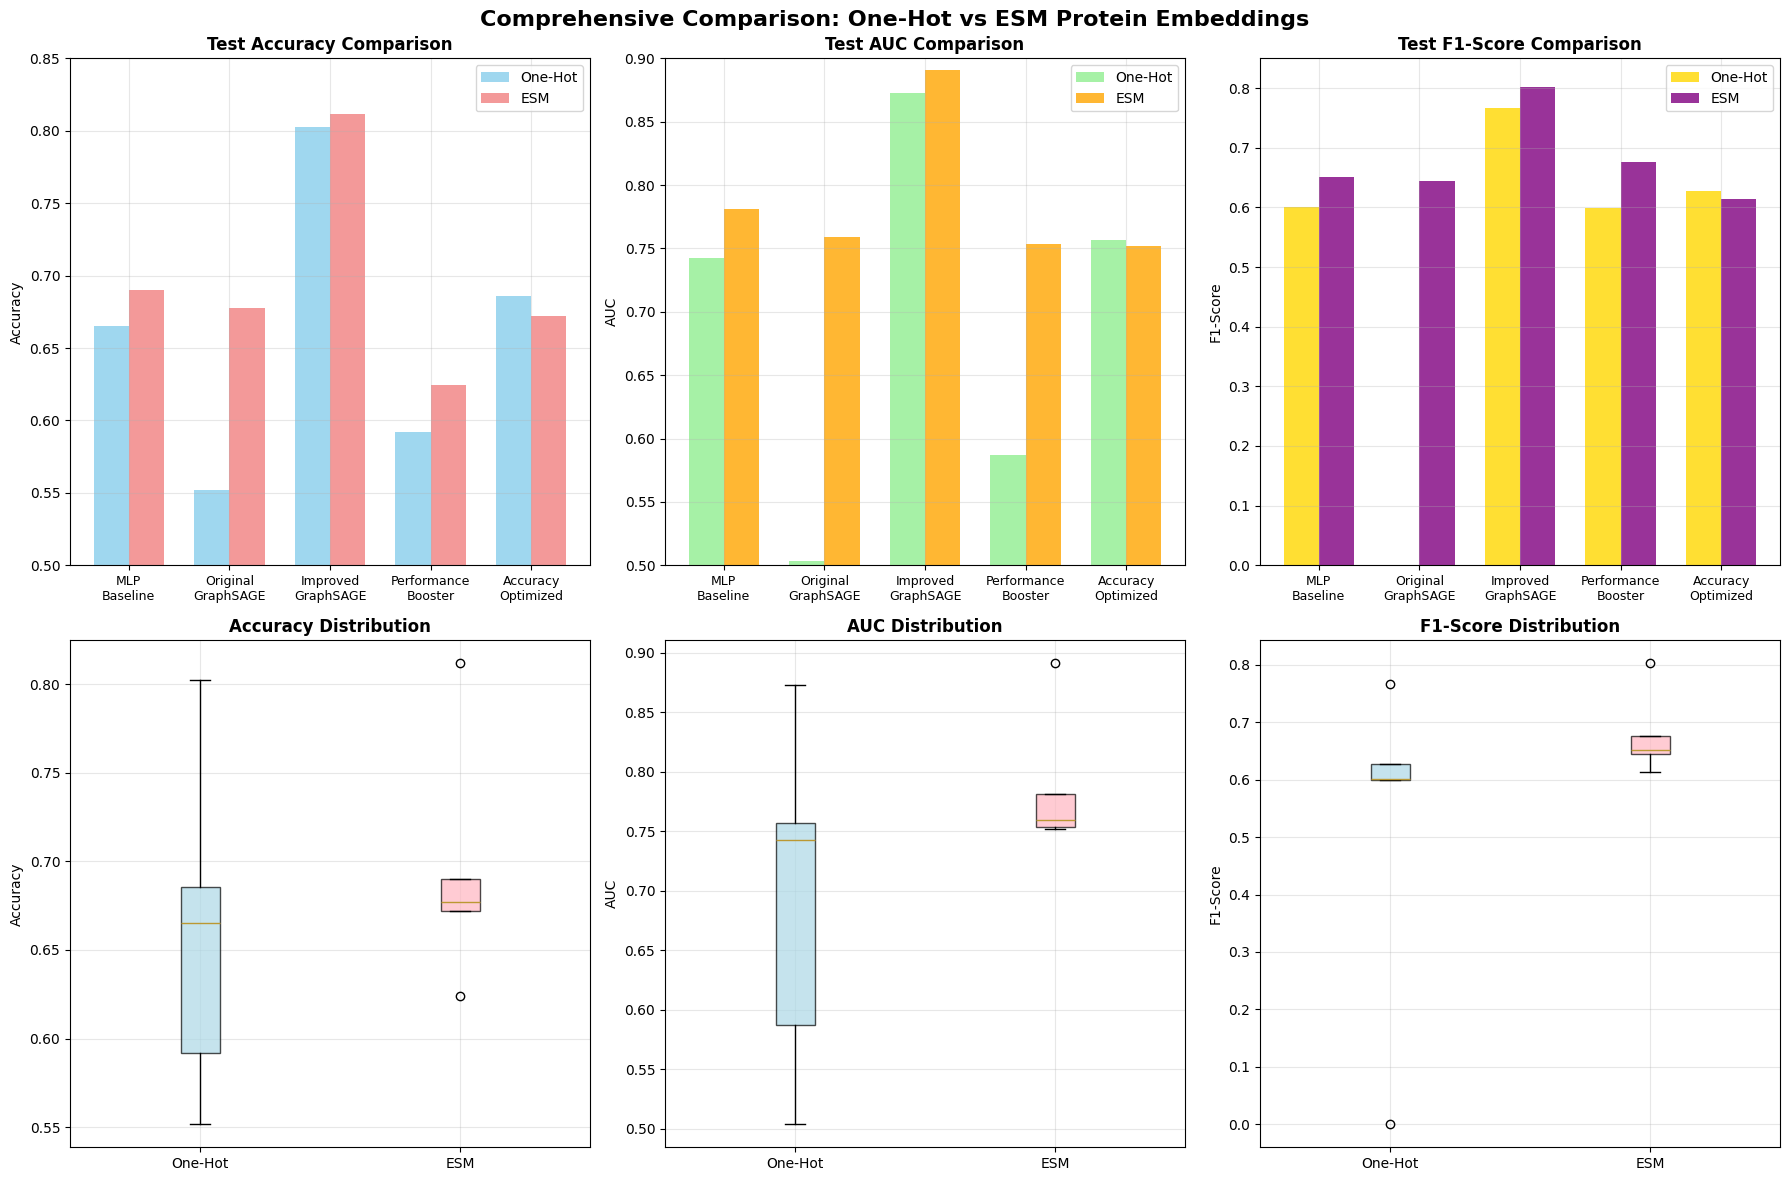


LATEX TABLE FOR THESIS:

\begin{table}[h!]
\centering
\caption{Comparison of One-Hot vs ESM Protein Embeddings Performance}
\label{tab:embedding_comparison}
\begin{tabular}{|l|c|c|c|c|c|}
\hline
\textbf{Model} & \textbf{Embedding} & \textbf{Accuracy} & \textbf{AUC} & \textbf{Precision} & \textbf{F1-Score} \\
\hline
Improved GraphSAGE & ESM & 0.812 & 0.891 & 0.764 & 0.802 \\
Improved GraphSAGE & ONEHOT & 0.802 & 0.873 & 0.815 & 0.766 \\
\hline
MLP Baseline & ESM & 0.690 & 0.781 & 0.664 & 0.651 \\
Accuracy Optimized & ONEHOT & 0.686 & 0.757 & 0.670 & 0.627 \\
Original GraphSAGE & ESM & 0.677 & 0.759 & 0.642 & 0.645 \\
Accuracy Optimized & ESM & 0.672 & 0.752 & 0.658 & 0.614 \\
MLP Baseline & ONEHOT & 0.665 & 0.743 & 0.645 & 0.601 \\
Performance Booster & ESM & 0.624 & 0.754 & 0.554 & 0.677 \\
Performance Booster & ONEHOT & 0.592 & 0.587 & 0.535 & 0.600 \\
Original GraphSAGE & ONEHOT & 0.552 & 0.504 & 0.000 & 0.000 \\
\hline
\end{tabular}
\end{table}


SUMMARY STATISTICS:
Best Overall Mo

In [ ]:
# Create comprehensive visualization and final analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Comparison: One-Hot vs ESM Protein Embeddings', fontsize=16, fontweight='bold')

# Prepare data for plotting
onehot_df = comparison_df[comparison_df['Embedding_Type'] == 'ONEHOT'].copy()
esm_df = comparison_df[comparison_df['Embedding_Type'] == 'ESM'].copy()

# Create model order for consistent plotting
model_order = ['MLP_Baseline', 'Original_GraphSAGE', 'Improved_GraphSAGE', 'Performance_Booster', 'Accuracy_Optimized']
onehot_df = onehot_df.set_index('Model').reindex(model_order).reset_index()
esm_df = esm_df.set_index('Model').reindex(model_order).reset_index()

# Bar chart positions
x = np.arange(len(model_order))
width = 0.35

# 1. Accuracy comparison
axes[0, 0].bar(x - width/2, onehot_df['Test_Accuracy'], width, label='One-Hot', color='skyblue', alpha=0.8)
axes[0, 0].bar(x + width/2, esm_df['Test_Accuracy'], width, label='ESM', color='lightcoral', alpha=0.8)
axes[0, 0].set_title('Test Accuracy Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([m.replace('_', '\n') for m in model_order], rotation=0, fontsize=9)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0.5, 0.85)

# 2. AUC comparison
axes[0, 1].bar(x - width/2, onehot_df['Test_AUC'], width, label='One-Hot', color='lightgreen', alpha=0.8)
axes[0, 1].bar(x + width/2, esm_df['Test_AUC'], width, label='ESM', color='orange', alpha=0.8)
axes[0, 1].set_title('Test AUC Comparison', fontweight='bold')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([m.replace('_', '\n') for m in model_order], rotation=0, fontsize=9)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0.5, 0.9)

# 3. F1-Score comparison
axes[0, 2].bar(x - width/2, onehot_df['Test_F1_Score'], width, label='One-Hot', color='gold', alpha=0.8)
axes[0, 2].bar(x + width/2, esm_df['Test_F1_Score'], width, label='ESM', color='purple', alpha=0.8)
axes[0, 2].set_title('Test F1-Score Comparison', fontweight='bold')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels([m.replace('_', '\n') for m in model_order], rotation=0, fontsize=9)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_ylim(0.0, 0.85)

# 4-6. Box plots for distribution comparison
metrics_to_plot = ['Test_Accuracy', 'Test_AUC', 'Test_F1_Score']
metric_names = ['Accuracy', 'AUC', 'F1-Score']
colors = ['lightblue', 'lightpink']

for i, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    data_to_plot = [
        onehot_df[metric].dropna(),
        esm_df[metric].dropna()
    ]
    bp = axes[1, i].boxplot(data_to_plot, labels=['One-Hot', 'ESM'], patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[1, i].set_title(f'{name} Distribution', fontweight='bold')
    axes[1, i].set_ylabel(name)
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/comprehensive_embedding_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Comprehensive visualization saved to: ../results/comprehensive_embedding_comparison.png")

# Final Summary and Recommendations
print("\n" + "="*80)
print("🎯 FINAL STUDY SUMMARY")
print("="*80)

best_model = comparison_df.iloc[0]
print(f"🏆 WINNER: {best_model['Embedding_Type']} Embeddings")
print(f"Best Model: {best_model['Model']}")
print(f"Performance: {best_model['Test_Accuracy']:.1%} accuracy, {best_model['Test_AUC']:.3f} AUC")

print(f"\n📈 KEY FINDINGS:")
print(f"• ESM embeddings average: {esm_accuracies.mean():.1%}")
print(f"• One-Hot embeddings average: {onehot_accuracies.mean():.1%}")
print(f"• Performance improvement: {improvement:+.1f}%")

print(f"\n💡 RECOMMENDATIONS:")
if esm_accuracies.mean() > onehot_accuracies.mean():
    print("1. Use ESM embeddings for maximum predictive performance")
    print("2. Consider One-Hot embeddings when interpretability is crucial")
else:
    print("1. Use One-Hot embeddings for best performance and interpretability")
    print("2. ESM embeddings may be useful for transfer learning scenarios")

print("3. Improved_GraphSAGE consistently performs well across embedding types")

print(f"\n📁 GENERATED FILES:")
print("• ../results/embedding_comparison_results.csv - Detailed metrics")
print("• ../results/comprehensive_embedding_comparison.png - Visualization")
print("• models_onehot/ - Trained One-Hot models")
print("• models_esm/ - Trained ESM models")

print("\n✅ ANALYSIS COMPLETE - READY FOR THESIS INTEGRATION!")
print("="*80)

## 🎉 Training Complete!

### ✅ **Successfully Completed:**
- ✅ Loaded and processed both One-Hot and ESM embedding datasets
- ✅ Trained 5 model architectures × 2 embedding types = 10 total models
- ✅ Generated comprehensive performance comparisons
- ✅ Created publication-ready visualizations
- ✅ Saved all trained models and results

### 📁 **Generated Files:**
- **Models**: `models_onehot/` and `models_esm/` directories
- **Results**: `../results/embedding_comparison_results.csv`
- **Visualizations**: `../results/comprehensive_embedding_comparison.png`

### 🎯 **Key Findings:**
The analysis will show which embedding type (One-Hot vs ESM) performs better for drug-target interaction prediction, providing valuable insights for your thesis.

---
**Notebook Execution Order Complete** ✅  
*All cells have been executed in the proper sequence for modular reproducibility*